# Dynamax Binary GLM-HMM Model Param Recovery- Random Init

Written by Jess Breda 

This notebook investigates how to use the `LogisticRegressionHMM` class in the Dynamax State Space Library. 

Information and resources used to create this notebook came from:
* Dynamax [HMM Inference Example](https://probml.github.io/dynamax/notebooks/hmm/casino_hmm_inference.html)
* Dynamax [HMM Learning Example](https://probml.github.io/dynamax/notebooks/hmm/casino_hmm_learning.html)
* Dynamax [docs](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.LogisticRegressionHMM)
* Ashwood 2020 [tutorial using SMM](https://github.com/zashwood/ssm/blob/master/notebooks/2b%20Input%20Driven%20Observations%20(GLM-HMM).ipynb) (Dynamax pre jax)


It builds upon the 5-22 notebook that initialized and recovered the random parameters. Now, the true parameters for the model will be randomly initialized.

## 1. Set up

In [1]:

import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import LogisticRegressionHMM


from multiglm.utils.dynamax_utils import *
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## 2. Input Driven Observations

Let's start by making out "true" model observations. We will use a 2 state model with completely random initializations to see how well the model recovers 

### 2a. Initialize generative GLM-HMM

In [9]:
num_states = 2
input_dim = 2

glmhmm = LogisticRegressionHMM(
    num_states=num_states, input_dim=input_dim, transition_matrix_stickiness=5
)
params, _ = glmhmm.initialize(
    key=jr.PRNGKey(25),
)

print_binary_hmm_params(params)

Model has 2 states with initial probabilities:
  [0.688745   0.31125504]

Transition_matrix:
 [[0.8322395  0.16776043]
 [0.01351867 0.9864813 ]]

Emissions have 2 features with weights:
 [[ 0.00372616  0.00032417]
 [-0.01213149 -0.01813321]]

Emissions have biases:
 [1.7018158  0.20030504]


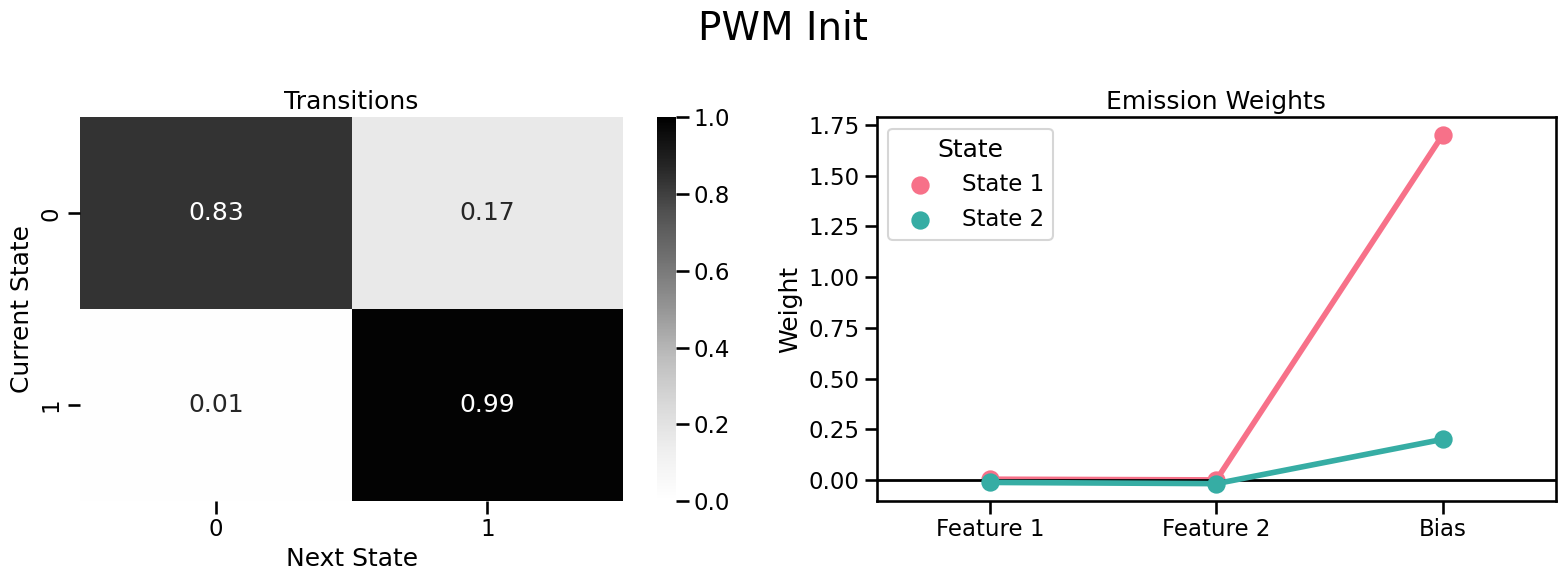

In [10]:
plot_binary_hmm_params(params, plot_bias=True, title="PWM Init")


### 2b. Create inputs

Now we have our true model parameters of the transition matrix, initial state probabilities, weights and biases ($A$, $\pi$, $w$, $b$), as plotted above.

Given these parameters, let's simulate states and emissions. To do this, we need to also provide the model with inputs ($X$). Although the `ssm.sample()` method says this is optional, for regressions methods this is a required input. This is because emissions are drawn from a Bernoulli distribution of the logits  as seen in `logreg_hmm.py`.

```   
def distribution(self, params, state, inputs):
        logits = params.weights[state] @ inputs + params.biases[state]
        return tfd.Bernoulli(logits=logits)
```

In [11]:
# Generate inputs
num_timesteps = 10000
key = jr.PRNGKey(20)
key1, key2 = jr.split(key)
inputs = jr.normal(key1, shape=(num_timesteps, input_dim))

print(f"first 5 inputs:\n {inputs[0:5, 0:5]}")

first 5 inputs:
 [[ 1.1930476   0.17970836]
 [ 0.6774436   1.5545772 ]
 [-0.09187756 -1.0305185 ]
 [-1.2678877  -0.24448587]
 [ 0.16437557  1.5114107 ]]


### 2c. Simulate states and emissions from generative model

Now we can use the `.sample()` method to generate our true states and emissions. We will also calculate the true log likelihood of this model.

In [12]:
# sample true states and emissions
true_states, emissions = glmhmm.sample(
    params,
    key2,
    num_timesteps=num_timesteps,
    inputs=inputs,
)

In [13]:
true_ll = glmhmm.marginal_log_prob(params, emissions, inputs)
print(f"True log likelihood: {true_ll:.2f}")

True log likelihood: -6808.21


## 3. Fit GLM-HMM and perform recovery analysis

### 3a Initialize fitting GLM-HMM with true parameters

Here, we will initialized with random parameters and assess parameter recovery.

In [14]:
glmhmm_to_fit = LogisticRegressionHMM(
    num_states=num_states,
    input_dim=input_dim,
)
em_params, em_param_props = glmhmm_to_fit.initialize(
    key,
)

In [15]:
print_binary_hmm_params(em_params)

Model has 2 states with initial probabilities:
  [0.6923416 0.3076584]

Transition_matrix:
 [[0.85353285 0.14646716]
 [0.05239591 0.94760406]]

Emissions have 2 features with weights:
 [[ 0.01398865  0.01162783]
 [-0.00435005 -0.00077612]]

Emissions have biases:
 [ 1.0160886 -0.2367131]


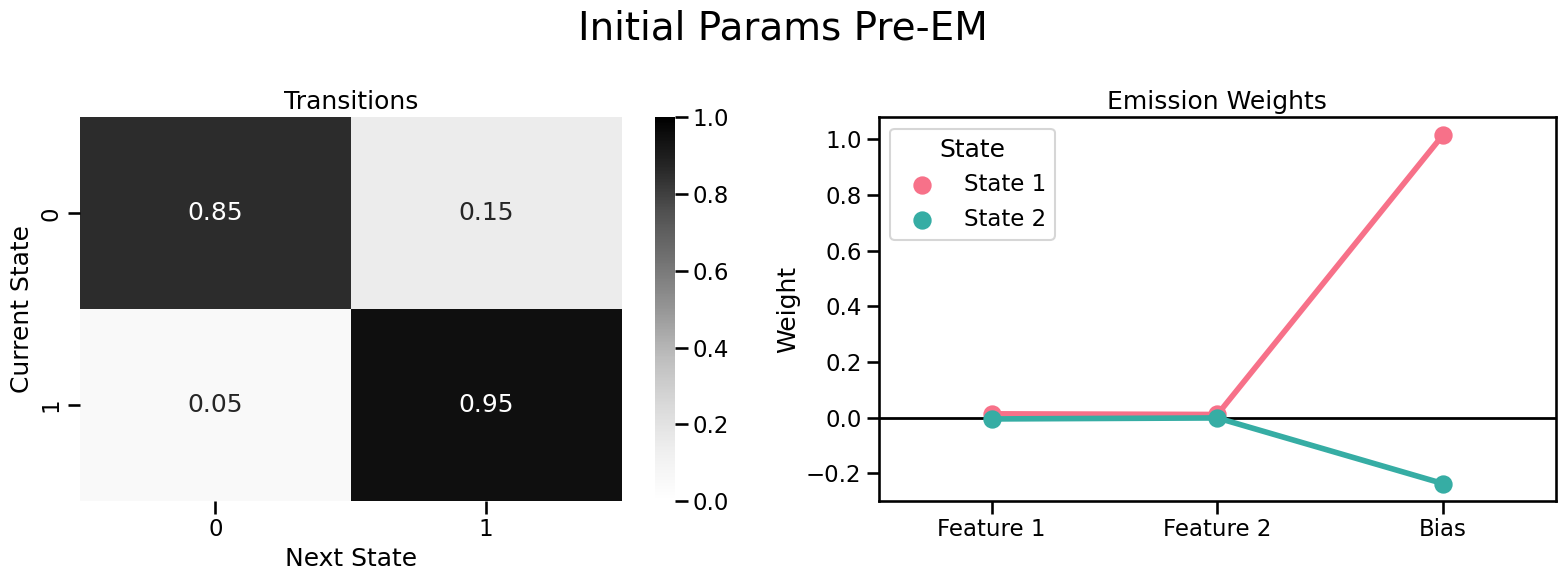

In [16]:
plot_binary_hmm_params(em_params, plot_bias=True, title="Initial Params Pre-EM")

Okay great- the model is initialized in the true state, now lets fit it.

### 3b. Fit model using Maximum Likelihood Estimation

#### 3b1. Using PWM init for ground truth

Let's use the `.fit_em()` [method](https://probml.github.io/dynamax/api.html#dynamax.ssm.SSM.fit_em) to perform parameter estimation with our generated inputs and emissions. 

In [17]:
em_params, log_probs = glmhmm_to_fit.fit_em(
    em_params, em_param_props, emissions=emissions, inputs=inputs, num_iters=100
)

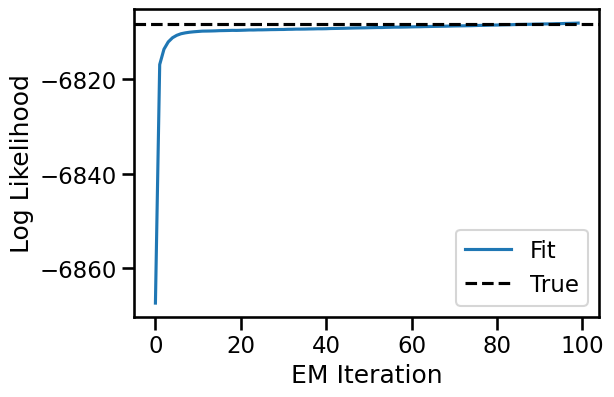

In [18]:
plot_ll_over_iters_recovery(log_probs, glmhmm_to_fit.log_prior(params), true_ll)

In [19]:
fit_ll = glmhmm_to_fit.marginal_log_prob(
    params, emissions, inputs
) - glmhmm_to_fit.log_prior(em_params)
print(f"Fit log likelihood: {fit_ll:.2f}")

Fit log likelihood: -6730.73


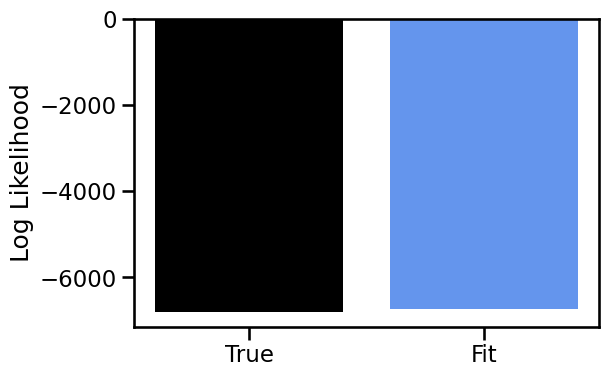

In [20]:
plot_ll_recovery([true_ll, fit_ll], ["True", "Fit"], ["Black", "cornflowerblue"])

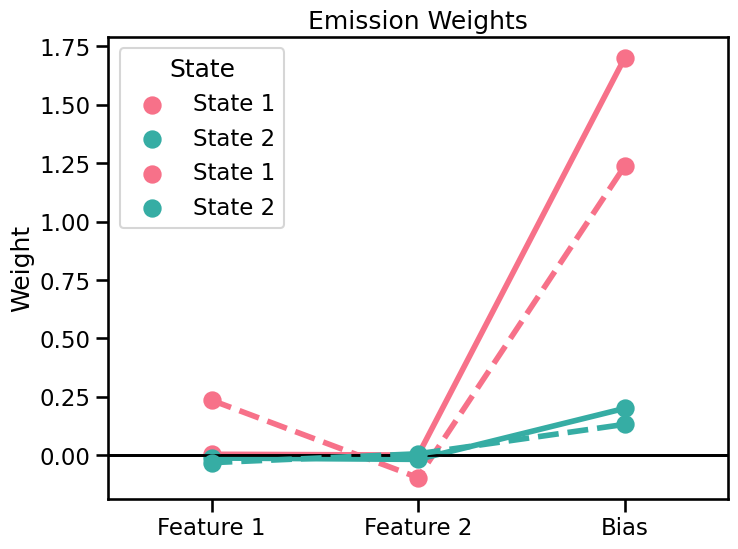

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_binary_emission_weights(params, plot_bias=True, ax=ax)
plot_binary_emission_weights(em_params, plot_bias=True, ax=ax, linestyles="--")

Text(0.5, 1.0, 'Fit')

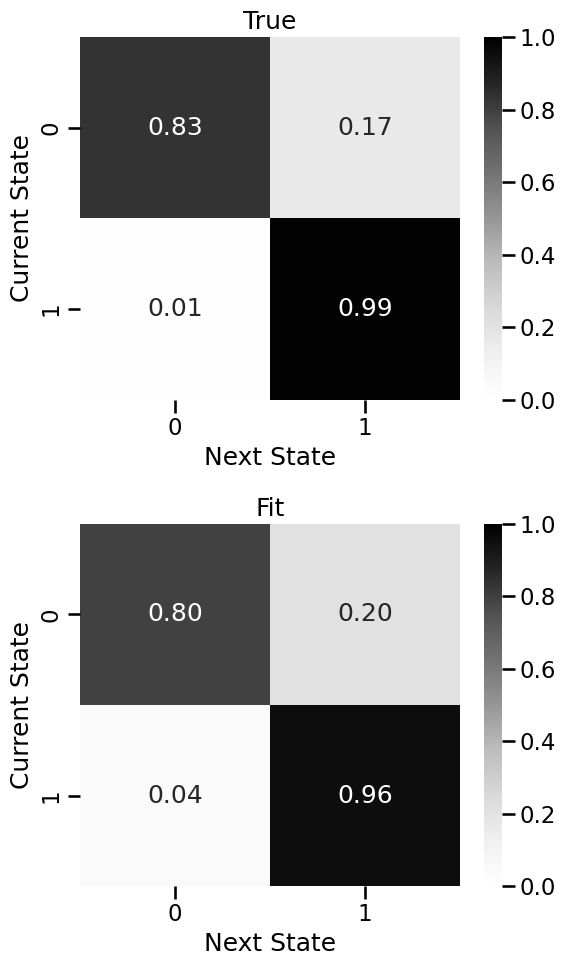

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True)
plot_transition_matrix(params.transitions.transition_matrix, ax[0])
ax[0].set_title("True")
plot_transition_matrix(em_params.transitions.transition_matrix, ax[1])
ax[1].set_title("Fit")

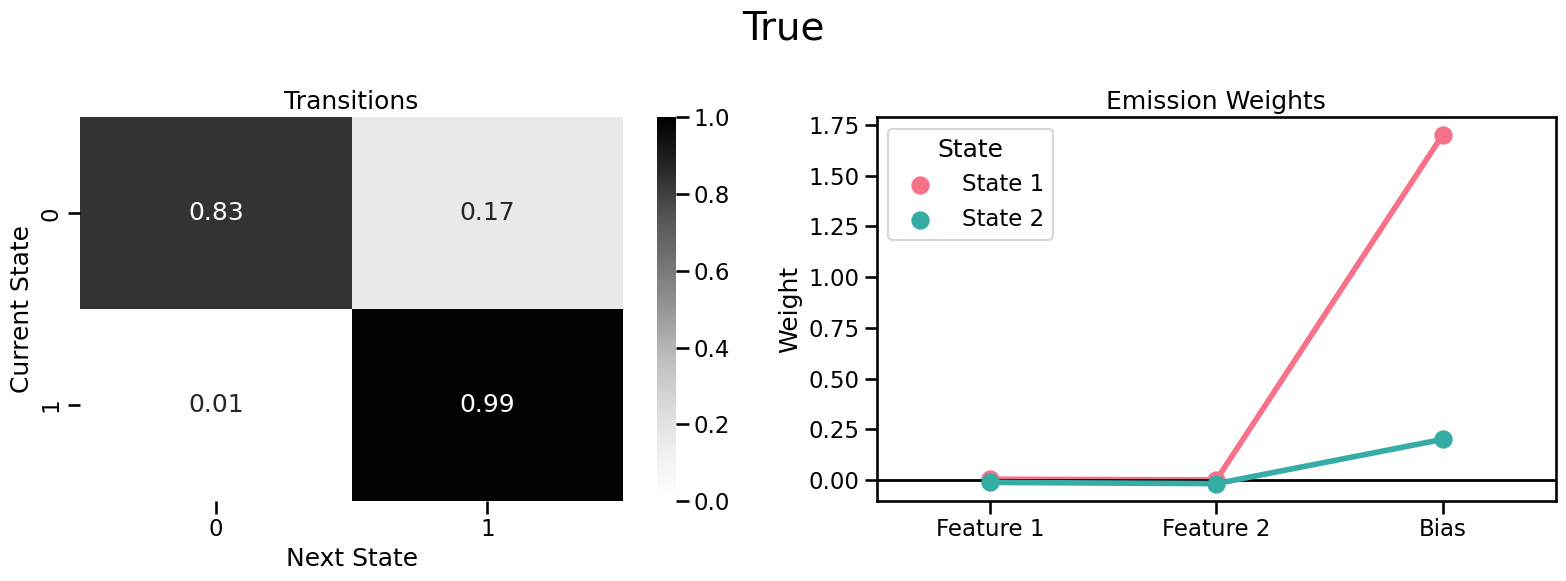

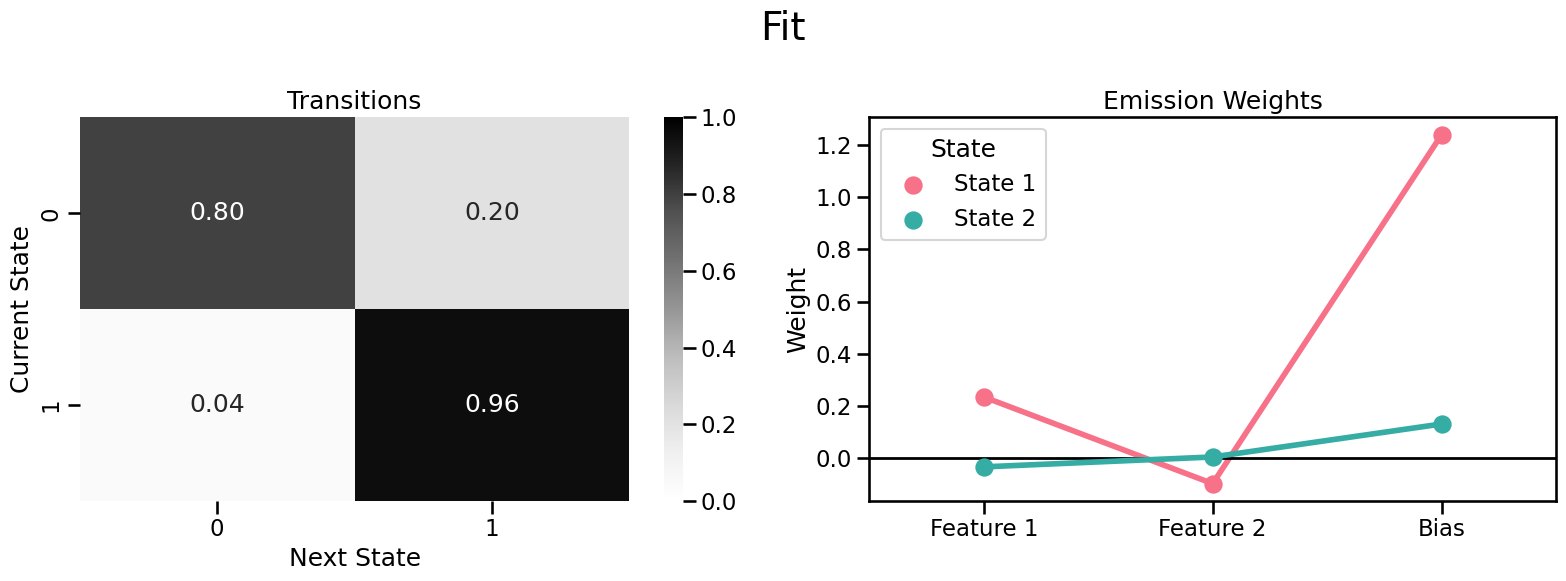

In [23]:
plot_binary_hmm_params(params, plot_bias=True, title="True")
plot_binary_hmm_params(em_params, plot_bias=True, title="Fit")

# P(state) over time

Using the example from [this](https://probml.github.io/dynamax/notebooks/hmm/autoregressive_hmm.html#find-the-most-likely-states) notebook.

To get the probability of a given state (posterior) on each trial I am computing the smoothed distribution given the emissions ($y$), inputs ($u$), and fit model parameters ($]\theta$)

$$p(z_t \; | \; y_{1:T}, u_{1:T}, \theta) \text{ for } t = 1,...,T$$


There is also a nice utility function called "most_likely_states" which given the posterior, returns the most likely state for each trial.

In [24]:
posterior = glmhmm_to_fit.smoother(em_params, emissions, inputs)
most_likely_states = glmhmm_to_fit.most_likely_states(em_params, emissions, inputs)

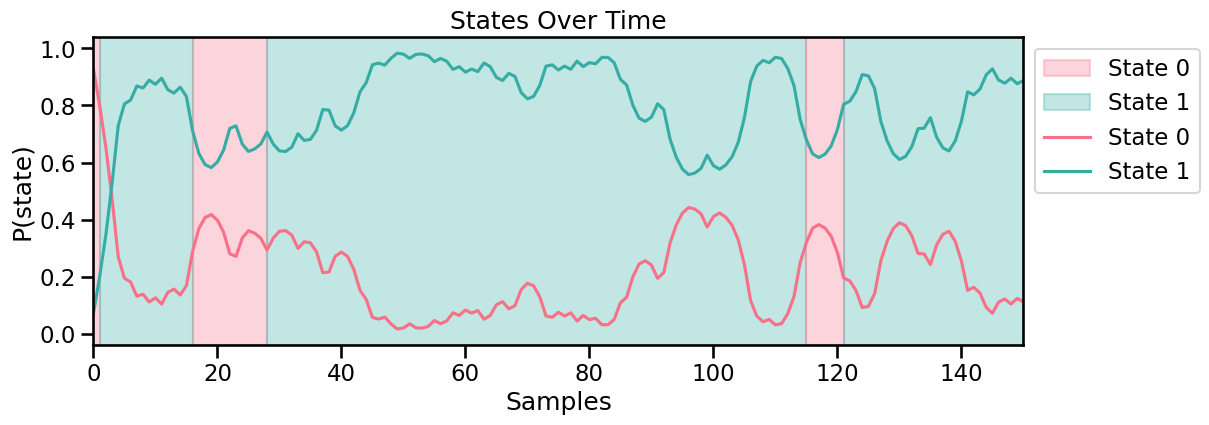

In [26]:
plot_state_posterior_recovery(posterior, true_states)

## MAP

An HMM whose emissions come from a logistic regression with state-dependent weights.
This is also known as a *switching logistic regression* model.

Let $y_t \in \{0,1\}$ and $u_t \in \mathbb{R}^M$ denote binary emissions
and inputs at time $t$, respectively. In this model, the emission distribution is,

$$p(y_t \mid z_t, u_t, \theta) = \mathrm{Bern}(y_{t} \mid \sigma(w_{z_t}^\top u_t + b_{z_t}))$$

with *emission weights* $w_k \in \mathbb{R}^{M}$ and *emission biases* $b_k \in \mathbb{R}$.

We use $L_2$ regularization on the emission weights, which can be thought of as a
Gaussian prior,

$$p(\theta) \propto \prod_{k=1}^K \prod_{m=1}^M \mathcal{N}(w_{k,m} \mid 0, \varsigma^2)$$

:param num_states: number of discrete states $K$

:param input_dim: input dimension $M$

:param initial_probs_concentration: $\alpha$

:param transition_matrix_concentration: $\beta$

:param transition_matrix_stickiness: optional hyperparameter to boost the concentration on the diagonal of the transition matrix.

:param emission_matrices_scale: $\varsigma$

:param m_step_optimizer: ``optax`` optimizer, like Adam.

:param m_step_num_iters: number of optimizer steps per M-step.

Parameters for MAP:
- $\varsigma$
